## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
import scipy

import pydicom

import glob

import matplotlib.image as image

from skimage import io

import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

## Do some early processing of your metadata for easier model training:

In [42]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob.glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
3322,00000877_016.png,No Finding,16,877,39,M,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000877_016.png
62662,00015524_004.png,Edema|Infiltration,4,15524,24,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00015524_004.png
55295,00013849_020.png,No Finding,20,13849,61,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00013849_020.png


In [43]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [44]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
87344,00021572_001.png,Edema|Infiltration,1,21572,27,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88950,00022065_012.png,No Finding,12,22065,46,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65808,00016244_003.png,No Finding,3,16244,61,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
all_xray_df.shape

(112120, 28)

In [46]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [47]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
 13 

## Create your training and testing data:

Students create a set of training data and a set of validation data that each have the appropriate proportions of positive and negative cases for their intended use (training and validation)

In [48]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(df, 
                                              test_size = 0.2, 
                                              stratify = df['pneumonia_class'])
    
    # check the ratio of positive train and validation set among all train/ validation df
    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Initial split. Train set pneumonia: {100.0*train_df_ratio :.2f}%. Valid set pneumonia: {100.0*valid_df_ratio :.2f}%')
    
    # have EQUAL amount of positive and negative cases of Pneumothorax in Training
    train_p = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    train_nonp = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()

    train_nonp_sample = sample(train_nonp, len(train_p))
    train_df = train_df.loc[train_p + train_nonp_sample]

    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'Train set corrected (50/50), pneumonia: {100.0*train_df_ratio :.2f}%')
    
    # To have 20% positive cases of pneumonia in the Test Set
    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.

    valid_p = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    valid_nonp = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    valid_nonp_sample = sample(valid_nonp, 4*len(valid_p))
    valid_df = valid_df.loc[valid_p + valid_nonp_sample]

    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Valid set corrected (20/80), pneumonia: {100.0*valid_df_ratio :.2f}%')
    
    
    return train_df, valid_df

In [49]:
# check the function and its division
df_train, df_valid = create_splits(all_xray_df)
print(f'train size: {len(df_train)}, valid size: {len(df_valid)}')

Initial split. Train set pneumonia: 1.28%. Valid set pneumonia: 1.28%
Train set corrected (50/50), pneumonia: 50.00%
Valid set corrected (20/80), pneumonia: 20.00%
train size: 2290, valid size: 1430


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [50]:
# define image size, below is the example on the lesson, assuming the most common
IMG_SIZE = (224, 224)

In [51]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

    return idg


def make_train_gen(df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    train_idg = my_image_augmentation(df)
    
    train_gen = train_idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32
                                         )
    
    return train_gen


def make_valid_gen(df, batch_size):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    #val_idg = my_image_augmentation(df)
    
    val_gen = val_idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )
    return val_gen

In [52]:
# check the function of augmentation
train_gen = make_train_gen(df_train)

batch_size = 32
val_gen = make_valid_gen(df_valid, batch_size)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


**Remarks**: The result is the same amount of traind and validation set as we split it previously

In [53]:
# see the count the non and pneumonia class in train data
df_train['pneumonia_class'].value_counts()

N    1145
Y    1145
Name: pneumonia_class, dtype: int64

In [54]:
# see the count the non and pneumonia class in validation data
df_valid['pneumonia_class'].value_counts()

N    1144
Y     286
Name: pneumonia_class, dtype: int64

In [55]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

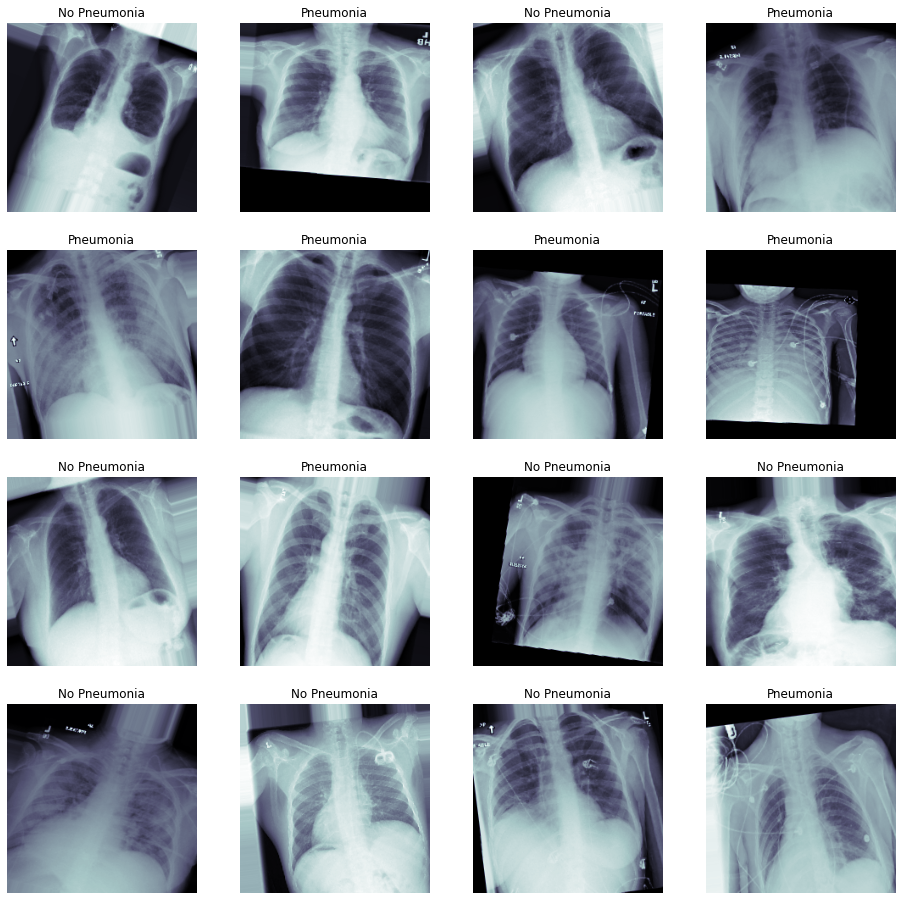

In [56]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

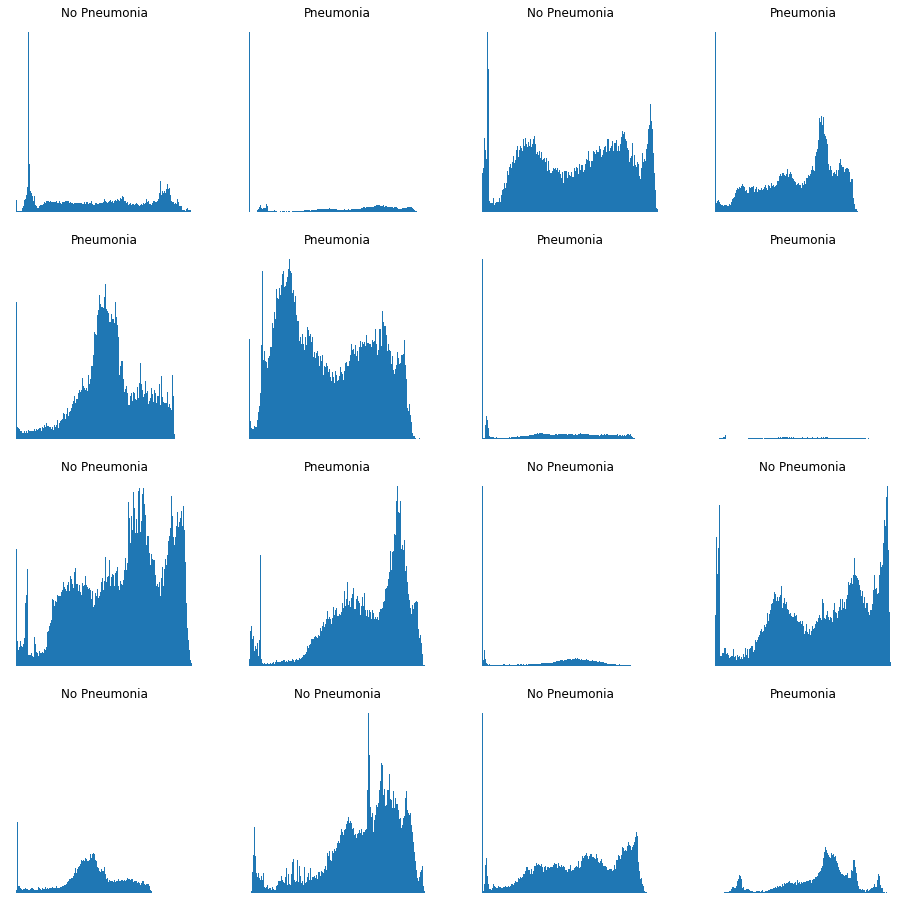

In [57]:
# see the intensity distributon histogram with the similar code as the cell below
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.hist(c_x[:,:,0].ravel(), bins = 256)
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    
plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [58]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=True, weights='imagenet')
    print(model.summary())
    
    transfer_layer = model.get_layer('block5_pool')
    
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

    return vgg_model

Changes training parameters to avoid overfitting and compares performances of different training paradigms.


In [59]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    vgg_model = load_pretrained_model()
    
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    new_model.add(Flatten())
    
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has recognized in the image.
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))

    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.5))

    # Change the activation function to sigmoid so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    return new_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Monitors the training progress of the model using log loss

In [60]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [61]:
model = build_my_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Start training! 

Trains enough epochs until the loss is “stable”

In [81]:
## train your model

## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics=['binary_accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 74s 1s/step - loss: 0.6648 - binary_accuracy: 0.6096 - val_loss: 0.6750 - val_binary_accuracy: 0.5895

Epoch 00001: val_loss did not improve from 0.51853
Epoch 2/100
72/72 [==============================] - 64s 895ms/step - loss: 0.6540 - binary_accuracy: 0.6140 - val_loss: 0.6875 - val_binary_accuracy: 0.6028

Epoch 00002: val_loss did not improve from 0.51853
Epoch 3/100
72/72 [==============================] - 65s 900ms/step - loss: 0.6523 - binary_accuracy: 0.6279 - val_loss: 0.6490 - val_binary_accuracy: 0.6406

Epoch 00003: val_loss did not improve from 0.51853
Epoch 4/100
72/72 [==============================] - 65s 902ms/step - loss: 0.6450 - binary_accuracy: 0.6314 - val_loss: 0.7222 - val_binary_accuracy: 0.5622

Epoch 00004: val_loss did not improve from 0.51853
Epoch 5/100
72/72 [==============================] - 64s 891ms/step - loss: 0.6465 - binary_accuracy: 0.6293 - val_loss: 0.6612 - val_binary_accuracy: 0.6315

Epoc

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

### Predictions

In [99]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

batch_size = 1430
val_gen_1 = make_valid_gen(df_valid, batch_size)
valX, valY = val_gen_1.next()

model.load_weights(weight_path)

# predictthe validation set
pred_Y = model.predict(valX, verbose = True)

Found 1430 validated image filenames belonging to 2 classes.
1430/1430 [==============================] - 13s 9ms/step


In [100]:
pred_Y

array([[0.23499352],
       [0.3672441 ],
       [0.63057697],
       ...,
       [0.4637475 ],
       [0.25042295],
       [0.4159098 ]], dtype=float32)

In [101]:
def plot_history(history):    
    N = len(history.history["loss"])
    
    ax = plt.figure()
    ax.set_figwidth(10)
    
    ax.add_subplot(1, 2, 1)
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.legend(loc="lower left")
    
    ax.add_subplot(1, 2, 2)
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.legend(loc="lower left")
    
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")

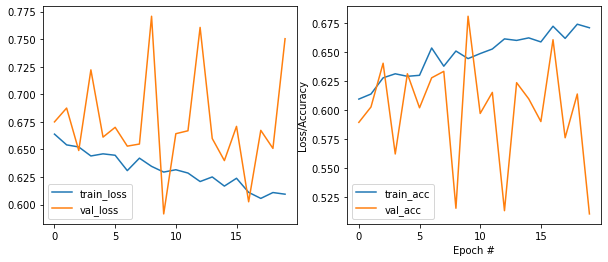

In [102]:
plot_history(history)

**Remarks**: Around the 3rd epoch, there is a decrease on the train and validation loss. The train loss keeps decreasing. 

Around the 5th epoch, both the train and validation accuracy increase and the train accuracy keeps increasing. 

It seems like after the 7th epoch, there is no significant imporvement on the models.

After training, uses precision, recall, and F1 score to actually evaluate the utility of their model.

Show precision-recall curve and a curve of F1-score vs. threshold


In [103]:
def plot_auc(t_y, p_y): # roc-auc curce
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    '''
    args: true positive from validation, prediction
    return: plot auc-roc curve
    '''
#     fpr, tpr, thres = roc_curve(t_y, p_y, pos_label=1)
#     plt.plot(fpr, tpr, color='red', lw=2)
#     plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
#     plt.xlabel('FPR')
#     plt.ylabel('TPR')
#     plt.title('ROC Curve')    
#     plt.show()
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thres = roc_curve(t_y, p_y, pos_label=1)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.title('ROC Curve')    
    plt.show()
    
    ## what other performance statistics do you want to include here besides AUC? 

def plot_pres_rec_f1(t_y, p_y):
    '''
    args: true positive from validation, prediction
    return: plot precision - recall, plot f1 scores and their values
    '''
    ax = plt.figure()
    ax.set_figwidth(15)
    
    s1 = ax.add_subplot(1, 2, 1)
    pres, rec, thres = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(rec, pres, color='green', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    s2 = ax.add_subplot(1, 2, 2)
    f1_scores = calc_f1(pres, rec)
    plt.plot(thres, f1_scores[0:len(thres)])
    plt.title('F1- Thresholds Curve')
    plt.xlabel('Thresholds')
    plt.ylabel('F1 Scores')
    plt.show()
    
    return calc_f1(pres,rec), pres, rec, thres

def calc_f1(prec,recall):
    '''
    args: precision and recall values
    return: calculation of precision and recall
    '''
    return 2*(prec*recall)/(prec+recall)

# Also consider plotting the history of your model training: (done in the above cell)

def plot_history(history):
    return


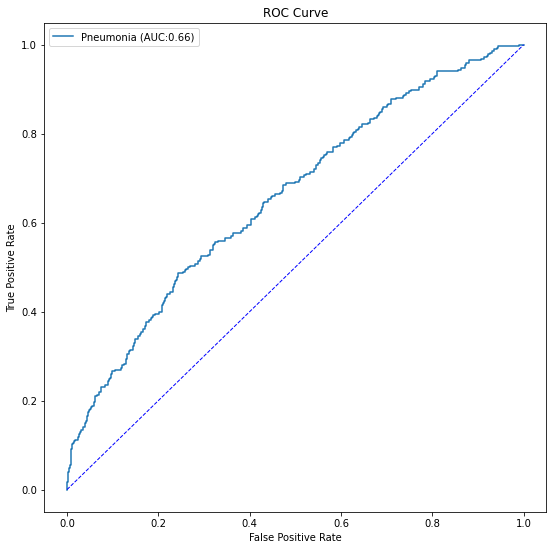

0.6567650007335322

In [104]:
## plot figures
plot_auc(valY, pred_Y)
roc_auc_score(valY, pred_Y)

**Remarks**: The curve shows that the model is better than the threshold/ random classifier. There is quite a balance of TPR and FPR, when TPR increases, so does the FPR but not the same values. 

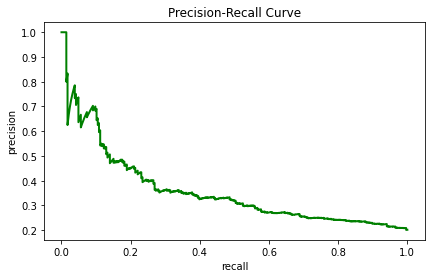

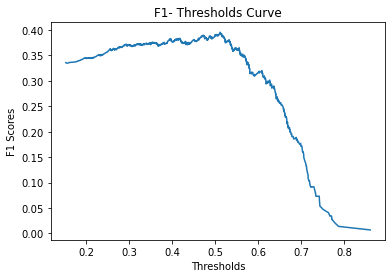

In [105]:
f1_score, precision, recall, thresholds  = plot_pres_rec_f1(valY, pred_Y)

In [106]:
# dataframe for metrics
df_metrics = pd.DataFrame({'f1':f1_score[:-1], 'prec':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})
df_metrics.sort_values(by='thresholds', ascending = True).head()

,f1,prec,recall,thresholds
0,0.335681,0.201693,1.000000,0.152343
1,0.334703,0.201129,0.996503,0.154715
2,0.334900,0.201271,0.996503,0.158020
3,0.335097,0.201413,0.996503,0.158402
4,0.335294,0.201556,0.996503,0.159125


In [107]:
df_metrics.describe()

,f1,prec,recall,thresholds
count,1418.000000,1418.000000,1418.000000,1418.000000
mean,0.346172,0.302485,0.622595,0.418920
std,0.059757,0.109858,0.272913,0.148842
min,0.006969,0.201129,0.003497,0.152343
25%,0.345167,0.234747,0.409091,0.292419
50%,0.368481,0.266713,0.660839,0.406581
75%,0.375000,0.332408,0.877622,0.538737
max,0.395448,1.000000,1.000000,0.859835


In [108]:
print('Maximum f1:', df_metrics['f1'].max())
threshold = df_metrics.iloc[df_metrics['f1'].idxmax()]['thresholds']
print('Threshold:', threshold)

Maximum f1: 0.39544807965860596
Threshold: 0.5112852454185486


In [109]:
print('Maximum precision:', df_metrics['prec'].max())
threshold = df_metrics.iloc[df_metrics['prec'].idxmax()]['thresholds']
print('Threshold:', threshold)

Maximum precision: 1.0
Threshold: 0.7712112069129944


In [110]:
print('Maximum recall:', df_metrics['recall'].max())
threshold = df_metrics.iloc[df_metrics['recall'].idxmax()]['thresholds']
print('Threshold:', threshold)

Maximum recall: 1.0
Threshold: 0.15234346687793732


**Remarks**: The result shows that with higher recall, the precision is and f1 socre are low, such as for the threshold of 0.26. When the recall is low, with threshold around 0.60, the f1 score is low as well but the precision is relatively higher. 

The median threshold is 0.43, we might use this for our threshold as well.

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Find a threshold to classify if an image is pneumonia or not.

In [116]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
THRESHOLD = 0.50
testY = valY

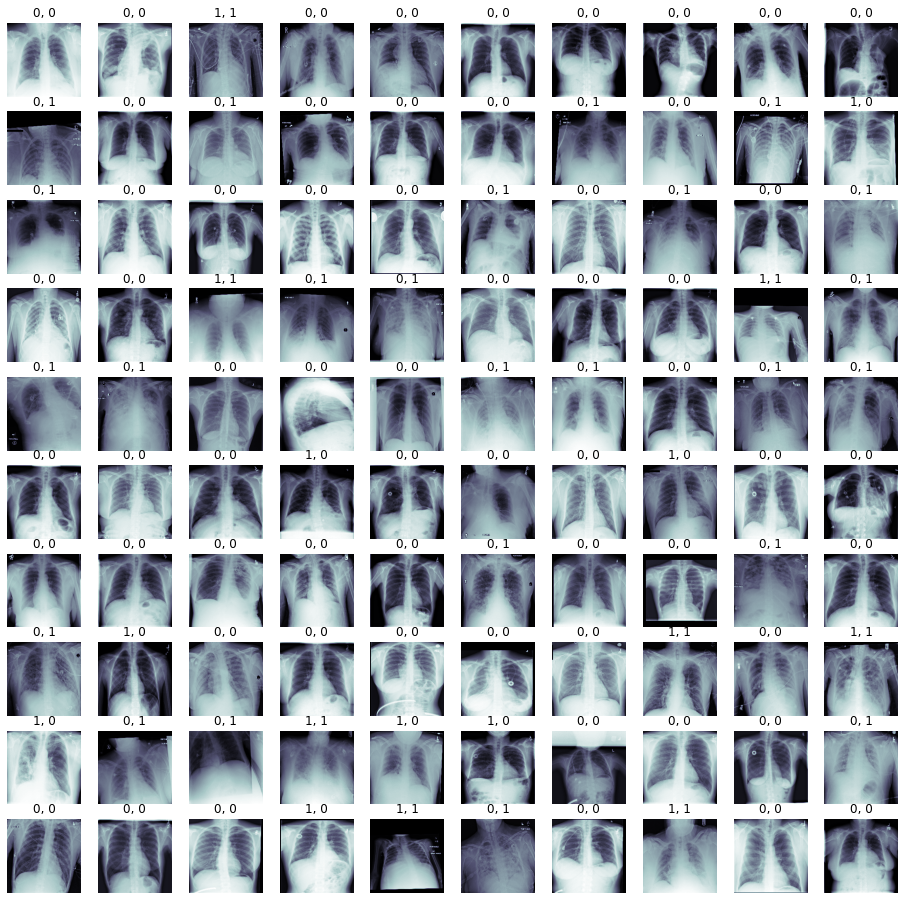

In [117]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [118]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

In [119]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [120]:
# check whether it is saved
!ls

'Build and train model.ipynb'	    test1.dcm
 EDA.ipynb			    test2.dcm
 FDA_Submission_Template-Copy1.md   test3.dcm
 FDA_Submission_Template.md	    test4.dcm
 Inference.ipynb		    test5.dcm
 my_model.json			    test6.dcm
 sample_labels.csv		    xray_class_my_model.best.hdf5


### Conclusion and Possible Improvements

The model has a quite good roc score which 0.66 and it has high recall, but low precision and f1 scores. With high recall, it might help radiologist to prioritize since it means that the model can predict well on the True Positive cases. 

To improve the model, we can try to remove the background first, and try to find the best the augmentation values.

### References

Most codes are attributed to the lessons provided by Udacity.